In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


/home/mauro/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
data = np.loadtxt('datos_observacionales.dat')

In [20]:
def dx(x,y,z,s,b,r):
    return s*(y-x)
def dy(x,y,z,s,b,r):
    return x*(r-z)-y
def dz(x,y,z,s,b,r):
    return x*y-b*z

def model(s,b,r):
    x= data[:,1][0]
    y= data[:,2][0]
    z= data[:,3][0]
    dt = 0.01
    t_here = 0 
    xs=[x]
    ys=[y]
    zs=[z]
    for i in range(int(3.0/dt)+1):
        x = x + dx(x,y,z,s,b,r)*dt
        y = y + dy(x,y,z,s,b,r)*dt
        z = z + dz(x,y,z,s,b,r)*dt
        t_here+=dt
        if(t_here%0.1 ==1):
            xs.append(x)
            ys.append(y)
            zs.append(z)
        
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    return xs,ys,zs

def loglikelihood(s, b, r):
    x_obs= data[:,1]
    y_obs= data[:,2]
    z_obs= data[:,3]
    
    xm,ym,zm = model(s,b,r)
    
    dx = x_obs -  xm
    dx = -0.5 * np.sum(dx**2)
    
    dy = y_obs -  ym
    dy = -0.5 * np.sum(dy**2)
    
    dz = z_obs -  zm
    dz = -0.5 * np.sum(dz**2)
    
    
    return dx+dy+dz

def logprior(s,b,r):
    p = -np.inf
    if s < 30 and s >0 and b >0 and b<30 and r < 30 and r>0:
        p = 0.0
    return p

In [81]:
# def pdf_to_sample(q, sigma):
#     return exp(-0.5*q**2/sigma**2)
ds = 0.1
db=0.1
dr=0.1

def log_pdf_to_sample(s,b,r):
    return loglikelihood(s,b,r)+logprior(r,b,r)

def gradient_log_pdf_to_samples(s,b,r):
    
    return (log_pdf_to_sample(s+ds,b,r)-log_pdf_to_sample(s,b,r))/ds

def gradient_log_pdf_to_sampleb(s,b,r):
    
    return (log_pdf_to_sample(s,b+db,r)-log_pdf_to_sample(s,b,r))/db

def gradient_log_pdf_to_sampler(s,b,r):
    
    return (log_pdf_to_sample(s,b,r+dr)-log_pdf_to_sample(s,b,r))/dr

def leapfrogs(s,b,r,ps,pb,pr, delta_t=1E-3, niter=5):
    s_new = s
    p_new = ps
    for i in range(niter):
        p_new = p_new + 0.5 * delta_t * gradient_log_pdf_to_samples(s_new,b,r) #kick
        s_new = s_new + delta_t * p_new #drift
        p_new = p_new + 0.5 * delta_t * gradient_log_pdf_to_samples(s_new,b,r) #kick
    return s_new, p_new

def leapfrogb(s,b,r,ps,pb,pr, delta_t=1E-3, niter=5):
    b_new = b
    p_new = pb
    for i in range(niter):
        p_new = p_new + 0.5 * delta_t * gradient_log_pdf_to_sampleb(s,b_new,r) #kick
        b_new = b_new + delta_t * p_new #drift
        p_new = p_new + 0.5 * delta_t * gradient_log_pdf_to_sampleb(s,b_new,r) #kick
    return b_new, p_new

def leapfrogr(s,b,r,ps,pb,pr, delta_t=1E-3, niter=5):
    r_new = r
    p_new = pr
    for i in range(niter):
        p_new = p_new + 0.5 * delta_t * gradient_log_pdf_to_sampler(s,b,r_new) #kick
        r_new = r_new + delta_t * p_new #drift
        p_new = p_new + 0.5 * delta_t * gradient_log_pdf_to_sampler(s,b,r_new) #kick
    return r_new, p_new

def H(s,b,r,ps,pb,pr):
    K = 0.5 * ps * ps +0.5 * pb * pb +0.5 * pr * pr 
    U = -log_pdf_to_sample(s,b,r)
    return K + U

def MCMC(nsteps):
    s = np.zeros(nsteps)
    ps = np.zeros(nsteps)
    
    b = np.zeros(nsteps)
    pb = np.zeros(nsteps)
    
    r = np.zeros(nsteps)
    pr = np.zeros(nsteps)
    
    ps[0] = np.random.uniform(0,1)
    s[0] =  np.random.uniform(0,30)
    pb[0] = np.random.uniform(0,1)
    b[0] =  np.random.uniform(0,30)
    pr[0] = np.random.uniform(0,1)
    r[0] =  np.random.uniform(0,30)
    
    sigma = 0.1
    for i in range(1,nsteps):
        print("\r"+str(i*100/nsteps),end="")
        
        ps[i] = np.random.normal(0,1)
        pb[i] = np.random.normal(0,1)
        pr[i] = np.random.normal(0,1)
        
        s_new, ps_new = leapfrogs(s[i-1],b[i-1],r[i-1],ps[i-1],pb[i-1], pr[i-1]) # la propuesta se hace con leapfrog
        b_new, pb_new = leapfrogb(s[i-1],b[i-1],r[i-1],ps[i-1],pb[i-1], pr[i-1]) # la propuesta se hace con leapfrog
        r_new, pr_new = leapfrogr(s[i-1],b[i-1],r[i-1],ps[i-1],pb[i-1], pr[i-1]) # la propuesta se hace con leapfrog
        
        ps_new = -ps_new #negamos a p para que la propuesta sea simetrica.
        pb_new = -pb_new #negamos a p para que la propuesta sea simetrica.
        pr_new = -pr_new #negamos a p para que la propuesta sea simetrica.
        
        
        
        E_new = H(s_new,b_new,r_new, ps_new, pb_new, pr_new) # En lugar de evaluar la pdf se evalua la energia.
        E_old = H(s[i-1],b[i-1],r[i-1],ps[i-1],pb[i-1], pr[i-1])
        alpha = min(1.0,np.exp(-(E_new - E_old))) # Se comparan las dos energias
        
#         print(i*100/nsteps,s[i-1],b[i-1],r[i-1],alpha)
#         print(s_new,b_new,r_new)
#         print(ps_new,pb_new,pr_new)
        beta = np.random.random()
        if beta < alpha:
            s[i] = s_new
            b[i] = b_new
            r[i] = r_new
#             print("entra")
        else:
            s[i] = s[i-1]
            b[i] = b[i-1]
            r[i] = r[i-1]
#             print("no entra")
    return s,b,r


In [82]:
s,b,r = MCMC(10000)

99.99

In [88]:
fig= plt.figure(figsize=(8,20))
plt.subplot(3,1,1)
plt.hist(s)
plt.title("Mean: {:.2f} Std:{:.2f}".format(np.mean(s),np.std(s)))
plt.subplot(3,1,2)
plt.hist(b)
plt.title("Mean: {:.2f} Std:{:.2f}".format(np.mean(b),np.std(b)))
plt.subplot(3,1,3)
plt.hist(r)
plt.title("Mean: {:.2f} Std:{:.2f}".format(np.mean(r),np.std(r)))
plt.savefig("histograms.png")
plt.close()

In [89]:
means = s.mean()
meanb = b.mean()
meanr = r.mean()


In [113]:
def model2(s,b,r):
    x= data[:,1][0]
    y= data[:,2][0]
    z= data[:,3][0]
    dt = 0.01
    t_here = 0 
    xs=[x]
    ys=[y]
    zs=[z]
    ts = [0]
    print(int(3.0/dt)+1)
    for i in range(int(3.0/dt)+1):
        x = x + dx(x,y,z,s,b,r)*dt
        y = y + dy(x,y,z,s,b,r)*dt
        z = z + dz(x,y,z,s,b,r)*dt
        t_here+=dt
        ts.append(t_here)
        xs.append(x)
        ys.append(y)
        zs.append(z)
        
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
#     print(xs)
    return xs,ys,zs,ts


301


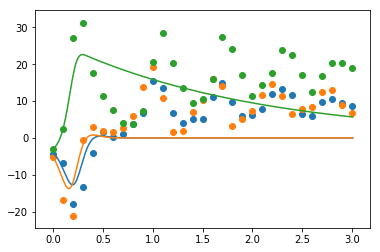

In [114]:
plt.scatter(data[:,0],data[:,1],label='x')
plt.scatter(data[:,0],data[:,2],label='y')
plt.scatter(data[:,0],data[:,3],label='z')
x,y,z,ts = model2(means,meanb,meanr)
# print(x)
plt.plot(ts,x)
plt.plot(ts,y)
plt.plot(ts,z)
# plt.legend()
plt.savefig('fit.png')